# Metaprogramming

## The ParticleGroup example

In [12]:
using Distributions, Plots, Sobol, LinearAlgebra

In [13]:
"""

     ParticleGroup{D,V}(n_particles, charge, mass)

 - `D` : Number of dimension in physical space
 - `V` : Number of dimension in phase space
 - `n` : number of particles
 
 """
 mutable struct ParticleGroup{D,V}

     n_particles       :: Int64
     data              :: Array{Float64, 2}

     function ParticleGroup{D,V}(n) where {D, V}

         data = zeros( Float64, (D+V, n))
         new( n, data) 
     end
 end

ParticleGroup

In [14]:
"""
    set_x( p, i, x )

Set position of ith particle of p to x when x is a vector
"""
@generated function set_x( p :: ParticleGroup{D,V}, i, x :: Vector{Float64} ) where {D, V}

     :(for j in 1:$D p.data[j, i] = x[j] end)

end

"""
    set_x( p, i, x)

Set position of ith particle of p to x

!!! note
    if `x` is a scalar value, only the first x dimension will be set.
"""
@generated function set_x( p :: ParticleGroup{D,V}, i, x :: Float64 ) where {D, V}

    :(p.particle_array[1, i] = x)

end

set_x

In [15]:
"""
    set_v( p, i, v)

Set velocity of ith particle of p to v
"""
@generated function set_v( p :: ParticleGroup{D,V}, i, v :: Vector{Float64} ) where {D, V}

    :(for j in 1:$V p.data[$D+j, i] = v[j] end)

end

"""
    set_v( p, i, v)

Set velocity of ith particle of p to v
"""
@generated function set_v( p :: ParticleGroup{D,V}, i, v :: Float64 ) where {D, V}

    :(p.data[$D+1, i] = v)

end

set_v

In [16]:
"""
     get_x( p, i )

Get position of ith particle of p
"""
@generated function get_x( p :: ParticleGroup{D,V}, i ) where {D, V}

     :(p.data[1:$D, i])

end

"""
     get_v( p, i )

Get velocity of ith particle of p
"""
@generated function get_v( p :: ParticleGroup{D,V}, i ) where {D, V}

     :(p.data[$D+1:$D+$V, i])
end

get_v

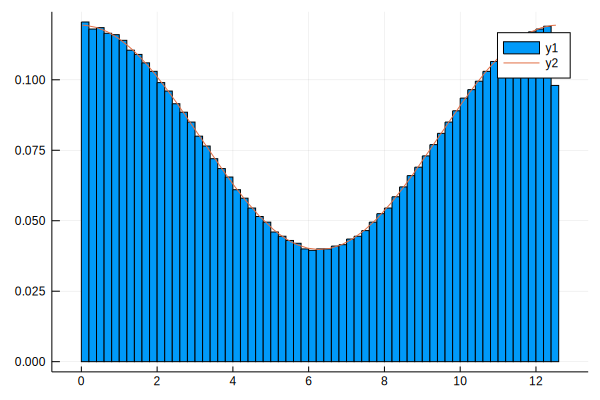

In [30]:
n_particles = 10000
alpha, kx = 0.5, 0.5
xmin, xmax, nx = 0.0, 2π/kx, n_particles
dx = (xmax - xmin) / (nx-1)
x = LinRange(xmin, xmax, nx)
f = 1 .+ alpha*cos.(kx .* x)
v = cumsum(f)*dx
s  = SobolSeq(1)
xp = Float64[]
for k = 1:n_particles
   r = next!(s)[1] * 4π
   j = findmin(abs.(v .- r) )[2]
   push!(xp,  x[j])
end

histogram(xp, normalize=true, bins = 100)
plot!(x-> (1+alpha*cos(kx*x))/4π, 0., 4π)

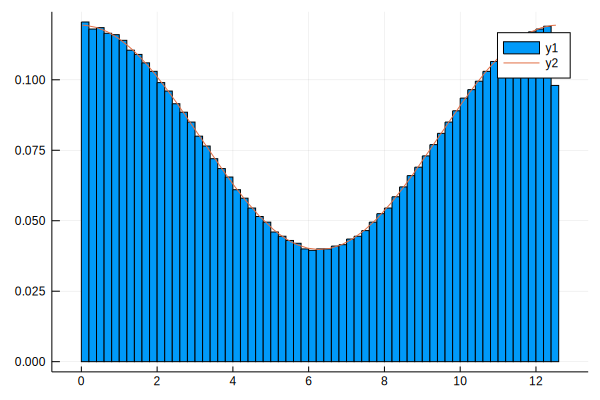

In [1]:
n_particles = 10
pg = ParticleGroup{1,2}(n_particles) # Create particles in 1D2V space


set_x!(pg, LinRange(0, 2π, n))
set_v!(pg, )
    
   

ArgumentError: ArgumentError: Package GEMPIC not found in current path:
- Run `import Pkg; Pkg.add("GEMPIC")` to install the GEMPIC package.


In [ ]:
n_particles = 100000
xmin        = 1.0 :: Float64
xmax        = 4π + 1.0
Lx          = xmax - xmin  
nx          = 64

mesh = Mesh( xmax, xmin, nx)

pg = ParticleGroup{1,2}(n_particles, 1.0, 1.0, 1)

params = ( dims        = (1,2),
           n_cos       = 1,
           n_gaussians = 1,
           kx          = hcat([0.5]),
           alpha       = [0.01],
           v_thermal   = hcat([0.1, 2.0]),
           v_mean      = hcat([0.0, 0.0]),
           δ           = 0.0
)

df1 = CosSumOneGaussian(params...)

mean_ref  = [Lx*0.5+xmin, 0.0, 0.0]
sigma_ref = [Lx^2/12.0,   df1.v_thermal[1,1]^2, df1.v_thermal[2,1]^2 ]

@info "Sobol non symmetric"
mean, sigma = test_sampling( :sobol, false, pg, df1 )
@show abs.(mean  .- mean_ref)
@show abs.(sigma .- sigma_ref)
@test maximum(abs.(mean .- mean_ref)) ≈ 0.0 atol = 1e2/sqrt(n_particles)

@info "Sobol symmetric"
mean, sigma = test_sampling( :sobol, true,  pg, df1 )
@show abs.(mean  .- mean_ref)
@show abs.(sigma .- sigma_ref)
@test maximum(abs.(mean .- mean_ref)) ≈ 0.0 atol = 1e-12

@info "Random non symmetric"
mean, sigma = test_sampling( :random, false, pg, df1)
@show abs.(mean  .- mean_ref)
@show abs.(sigma .- sigma_ref)
@test maximum(abs.(mean .- mean_ref)) ≈ 0.0 atol = 1e2/sqrt(n_particles)

@info "Random symmetric"
mean, sigma = test_sampling( :random, true,  pg, df1)
@show abs.(mean  .- mean_ref)
@show abs.(sigma .- sigma_ref)
@test maximum(abs.(mean .- mean_ref)) ≈ 0.0 atol = 1e-12
   
# Expected mean:
# 2π+1, 0, 0
# Expected variance:
# 16/12 π^2 , 0.01, 4

In [ ]:
params = (
    dims        = (1,2),
    n_cos       = 1,
    n_gaussians = 2,
    kx          = hcat([0.5]),
    alpha       = [0.01],
    v_thermal   = hcat([0.1, 2.0], [2.0, 2.0]),
    v_mean      = hcat([0.0, 0.0], [1.0, 1.0]),
    δ           = 0.7
)

df2 = CosSumOneGaussian(params...)

mean_ref = [Lx*0.5+xmin, 0.3, 0.3]
sigma_ref[1] = Lx^2/12.0
for j=1:2
    sigma_ref[j+1] = - (df2.delta[1] * df2.v_mean[j,1]
                      +(df2.delta[2] - df2.delta[1])*df2.v_mean[j,2])^2
    for k=1:2
        sigma_ref[j+1] += df2.delta[k] * (df2.v_thermal[j,k]^2
                                       +  df2.v_mean[j,k]^2)
    end
end
  
@info "Sobol non symmetric"
mean, sigma =  test_sampling( :sobol, false, pg, df2) 
@show abs.(mean  .- mean_ref)
@show abs.(sigma .- sigma_ref)
@test maximum(abs.(mean .- mean_ref)) ≈ 0.0 atol = 1e2/sqrt(n_particles)


@info "Sobol symmetric"
mean, sigma =  test_sampling( :sobol, true,  pg, df2) 
@show abs.(mean  .- mean_ref)
@show abs.(sigma .- sigma_ref)
@test maximum(abs.(mean .- mean_ref)) ≈ 0.0 atol = 1e2/sqrt(n_particles)